In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.dataset import EchoDataset, EchoDataset_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb

In [3]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join('saved_model', CFG['version'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [4]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [5]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 375   
    width = 500
    view = 'PLAX'
    dataset = 'EchoNetLVH'
    lr = 1e-3
    scheduler = 'LambdaLR'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 200
    patience = 50
    batch_size = 16

    ##############
    backbone = 'resnet101'
    version = '0.21'
    
CFG = cfg()

In [6]:
dataset_dir = 'output'

## 📀 Load Data

In [7]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        img = (img - img.min()) / (img.max() - img.min())
        return img


In [64]:
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    # A.HorizontalFlip(p=.5),
    A.VerticalFlip(p=.3),
    # A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2,
    #                 rotate_limit=10, p=0.2),
    A.SafeRotate(limit=30),

    A.OneOf([
        A.MedianBlur(blur_limit=3, p=0.1),
        A.MotionBlur(p=0.2),
    ], p=0.2),
    # A.OneOf([
    #     A.OpticalDistortion(p=0.3),
    # ], p=0.2),
    A.OneOf([
        A.GaussNoise(p=0.2),
        A.MultiplicativeNoise(p=0.2),
    ], p=0.2),
    A.HueSaturationValue(hue_shift_limit=0, sat_shift_limit=0,
                         val_shift_limit=0.1, p=0.3),
    MinMaxNormalize(p=1),

    # ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        # ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [65]:

ds = EchoDataset_heatmap(root=dataset_dir, split='train', transforms=test_ts)
dl = DataLoader(ds, batch_size=1, shuffle=False, )
s = dl.__iter__().__next__()
s

{'data': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],
 
          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': [[tensor([269.5312], dtype=torch.float64),
   tensor([149.9023], dtype=torch.float64)],
  [tensor([263.6719], dtype=torch.float64),
   tensor([166.503

In [ ]:
render_gaussian_dot_u(
    
)

In [68]:
torch.tensor(s['label']).flip(dims=[0,1]).shape, torch.tensor(s['label']).shape

(torch.Size([4, 2]), torch.Size([4, 2]))

In [59]:
from utils.heatmaps import *
a = torch.tensor([5,5], dtype=torch.float64)
heatmap = render_gaussian_dot_f(torch.tensor(s['label']).flip(dims=[0,1]), a, [375, 500])
b = heatmap.sum(axis=0)

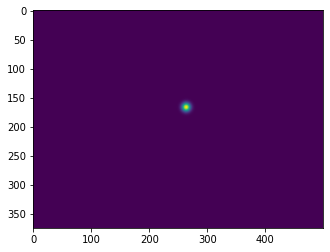

In [60]:
plt.imshow(b)

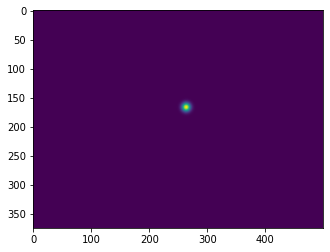

In [61]:
plt.imshow(b)

RuntimeError: shape '[-1, 4]' is invalid for input of size 2

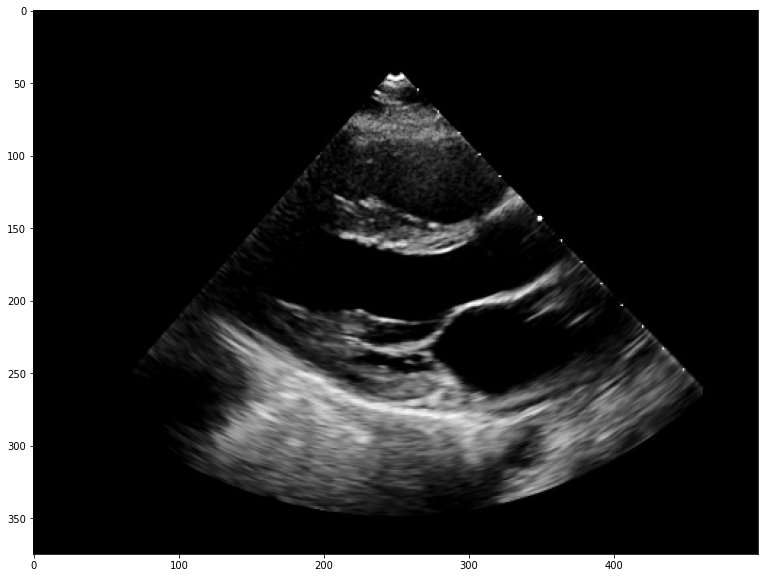

In [47]:
for i, sample in enumerate(dl):
    sample['label'] = torch.tensor(sample['label']).reshape(-1).to(torch.float32)
    show_lvh(sample)
    if i == 0:
        break

In [50]:
import cv2
frame = sample['data'].numpy()
frame_overlay =cv2.addWeighted(frame.squeeze()[0].astype(float), 1, 
                               b.numpy().astype(float), 1, 0)

/var/folders/rb/m57s2ktj2x16vll6kmm0sssm0000gn/T/ipykernel_43456/1774176630.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  coors = np.array(s['label'])
/var/folders/rb/m57s2ktj2x16vll6kmm0sssm0000gn/T/ipykernel_43456/1774176630.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  coors = np.array(s['label'])


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

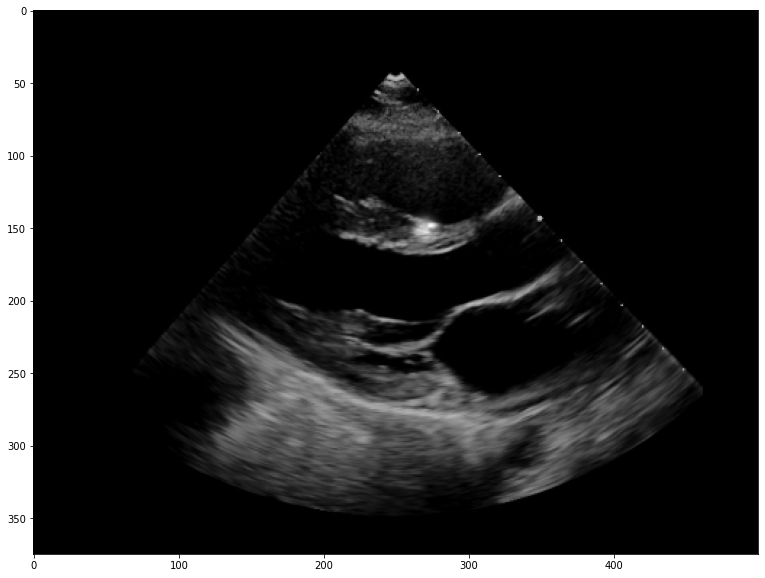

In [51]:
plt.figure(figsize=(15,10))
plt.imshow(frame_overlay, cmap='gray')
coors = np.array(s['label'])
for coor in coors.reshape(-1, 4):
    coor = coor.squeeze()
    plt.plot((coor[0], coor[2]),
            (coor[1], coor[3]), linewidth=3)
    plt.scatter((coor[0], coor[2]), (coor[1], coor[3]), )
plt.show()